# Mass matrix diagonalization (lumping)

In [1]:
from sympy import *
init_session()

IPython console for SymPy 1.0 (Python 3.6.0-64-bit) (ground types: python)

These commands were executed:
>>> from __future__ import division
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at http://docs.sympy.org/1.0/


## Elemental mass matrices

In [2]:
def mass_tet4():
    """Mass matrix for a 4 node tetrahedron"""
    r, s, t = symbols("r s t")
    N = Matrix([1 - r - s - t, r, s, t])
    return (N * N.T).integrate((t, 0, 1 - r - s), (s, 0, 1 - r), (r, 0, 1))


def mass_quad8():
    """Mass matrix for a 8 node quadrilateral"""
    r, s = symbols("r s")
    Haux = Matrix([
        (1 - r**2)*(1 + s),
        (1 - s**2)*(1 - r),
        (1 - r**2)*(1 - s),
        (1 - s**2)*(1 + r)])
    N = S(1)/4*Matrix([
            (1 + r)*(1 + s) - Haux[0] - Haux[3],
            (1 - r)*(1 + s) - Haux[0] - Haux[1],
            (1 - r)*(1 - s) - Haux[1] - Haux[2],
            (1 + r)*(1 - s) - Haux[2] - Haux[3],
           2*Haux[0], 2*Haux[1], 2*Haux[2], 2*Haux[3]])
    return (N * N.T).integrate((s, -1, 1), (r, -1, 1))   

The elemental mass matrices look like

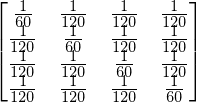

In [3]:
mass_tet4()

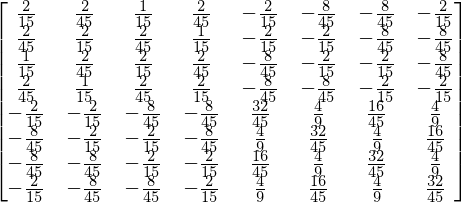

In [4]:
mass_quad8()

## Lumping

One method for lumping is to sum the matrix per rows, i.e.

$$M^\text{(lumped)}_{ii}= \sum_{j} M_{ij}$$

In [5]:
def row_lump(mass_mat):
    """Matrix lumping by row summing"""
    return diag(*[sum(mass_mat[i, :]) for i in range(mass_mat.shape[0])])

One method for lumping is to sum the matrix per rows, i.e.

$$M^\text{(lumped)}_{ii} = c M_{ii}$$

with $c$ adjusted to satisfy $\sum_j M^\text{(lumped)}_{jj} = \int_\Omega \rho d\Omega$. Particularly, we can choose $c = Tr(M)/M_\text{total}$.

In [6]:
def diag_scaling_lump(mass_mat):
    """Matrix lumping by diagonal scaling method"""
    mass = sum(mass_mat)
    trace = mass_mat.trace()
    c = mass/trace
    return diag(*[c*mass_mat[i, i] for i in range(mass_mat.shape[0])])

In [7]:
def min_dist_lump(mass_mat):
    """
    Matrix lumping by minimizing the Frobenius norm subject
    to a constraint of conservation of mass.
    """
    num = mass_mat.shape[0]
    mass = sum(mass_mat)
    lamda = symbols("lambda")
    Ms = symbols('M0:%d'%num)
    var = list(Ms)
    mass_diag = diag(*var)
    C = mass_mat - mass_diag
    fun = (C.T*C).trace() + lamda*(mass - sum(mass_diag))    
    var.append(lamda)
    grad = [diff(fun, x) for x in var]
    sol = solve(grad, var)
    return diag(*list(sol.values())[:-1])

We can compare the methods for the tetrahedron

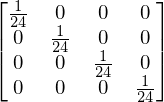

In [8]:
row_lump(mass_tet4())

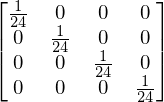

In [9]:
diag_scaling_lump(mass_tet4())

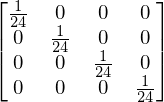

In [10]:
min_dist_lump(mass_tet4())

We can compare the methods for the serendipity quadrilaterals. For this type 
of element we can't use the row lumping method since it leads to negative
masses.

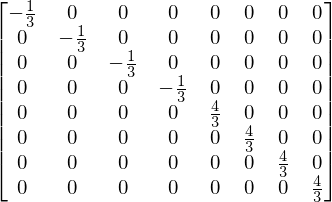

In [11]:
row_lump(mass_quad8())

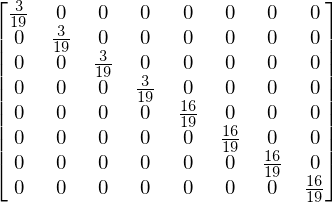

In [12]:
diag_scaling_lump(mass_quad8())

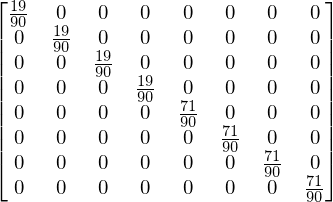

In [13]:
min_dist_lump(mass_quad8())

In [14]:
from IPython.core.display import HTML
def css_styling():
    styles = open('./styles/custom_barba.css', 'r').read()
    return HTML(styles)
css_styling()